# Principal Component Analysis (PCA) on Employee_data

The goal of Principal Component Analysis (PCA) is to reduce the **number of dimensions** of a d-dimensional dataset by projecting it onto a k-dimensional subspace (with k < d) in order to increase the **computational efficiency** while retaining most of the information.

The k dimensions that we keep (eigenvectors) are called "**principal components**".

The PCA approach requires to:

* Standardize the data.
* Obtain the Eigenvectors and Eigenvalues from a Singular Vector Decomposition (SVD).
* Choose the number k of principal components to keep.
* Construct a projection matrix with the selected k eigenvectors.
* Project original dataset to a k-dimensional feature subspace.

Choosing the number k can be done systematically by selecting the components that best describe the variance in our data. The amount of information (variance) contained by each eigenvector can be measured by the **explained variance**.

This notebook will display the explained variance for your dataset and help you choose the right amount of eigenvectors ("principal components").

* [Setup and loading the data](#setup)
* [Preprocessing of the data](#preprocessing)
* [Computation of the PCA](#pca)
* [Display of the explained variance](#explained-variance)
* [Retaining of the most significant components](#final-pca)
* [Visualizing the vectors in the original space](#original-space)

<center><strong>Select Cell > Run All to execute the whole analysis</strong></center>

## Setup and dataset loading <a id="setup" /> 

First of all, let's load the libraries that we'll use

In [49]:
%pylab inline
import sys                          
import pandas as pd, numpy as np             # Data manipulation 
from sklearn.decomposition import PCA        # The main algorithm
from matplotlib import pyplot as plt         # Graphing
import seaborn as sns                        # Graphing
from collections import defaultdict, Counter # Utils
sns.set(style="white")                       # Tuning the style of charts
import warnings                              # Disable some warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/codespace/.local/lib/python3.12/site-packages/IPython/core/magics/pylab.py:166: UserWarning: pylab import has clobbered these variables: ['yticks', 'xticks']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


The first thing we do is now to load the dataset and put aside the three main types of columns:

* Numerics
* Categorical
* Dates

Since analyzing PCA requires to have the data in memory, we are only going to load a sample of the data. Modify the following cell to change the size of the sample.

Also, by default, date features are not kept. Modify the following cell to change that.

In [50]:
dataset_limit = 10000
keep_dates = False

# load the data file within a Pandas dataframe (change the dataset name for a different project)
df = pd.read_excel('Employee_data.xlsx', index_col=0)
df.head()

,gender,bdate,educ,jobcat,salary,salbegin,jobtime,prevexp,minority,age
id,,,,,,,,,,
0,m,1952-02-03 00:00:00,15,3,57000,27000,98,144,0,61.0
1,m,1958-05-23 00:00:00,16,1,40200,18750,98,36,0,55.0
2,f,1929-07-26 00:00:00,12,1,21450,12000,98,381,0,84.0
3,f,1947-04-15 00:00:00,8,1,21900,13200,98,190,0,66.0
4,m,1955-02-09 00:00:00,15,1,45000,21000,98,138,0,58.0


In [51]:
# make a copy of the original dataframe
df_orig = df.copy()    

# dropping now some non relevant fields
#df = df.drop(["gender", "minority", "jobtime"], axis=1)

# Get the column names
numerical_columns = list(df.select_dtypes(include=[np.number]).columns)
categorical_columns = list(df.select_dtypes(include=[object]).columns)
date_columns = list(df.select_dtypes(include=['<M8[ns]']).columns)

# Print a quick summary of what we just loaded
print("Loaded dataset")
print("   Rows: %s" % df.shape[0])
print("   Columns: %s (%s num, %s cat, %s date)" % (df.shape[1], 
                                                    len(numerical_columns), len(categorical_columns),
                                                    len(date_columns)))

Loaded dataset
   Rows: 474
   Columns: 10 (8 num, 2 cat, 0 date)


## Preprocessing of the data <a id="preprocessing" />

Keep the dates as features if requested by the user

In [52]:
columns_to_drop = []
if keep_dates:
    df[date_columns] = df[date_columns].astype(int)*1e-9
else:
    columns_to_drop.extend(date_columns)

Get rid of the columns that contain too many unique values

In [53]:
DROP_LIMIT_ABS = 200
CAT_DROP_LIMIT_RATIO = 0.5
for feature in categorical_columns:
    nu = df[feature].nunique()
    
    if nu > DROP_LIMIT_ABS or nu > CAT_DROP_LIMIT_RATIO*df.shape[0]:
        print("Dropping feature %s with %s values" % (feature, nu))
        columns_to_drop.append(feature)

Dropping feature bdate with 462 values


We then need to impute missing values (or drop the records)

In [54]:
impute = True

if impute:
    # Use mean for numerical features
    for feature in numerical_columns:
        v = df[feature].mean()
        if np.isnan(v):
            v = 0
        print("Filling %s with %s" % (feature, v))
        df[feature] = df[feature].fillna(v)

    # Use mode for categorical features
    for feature in categorical_columns:
        v = df[feature].value_counts().index[0]
        df[feature] = df[feature].fillna(v)

else:        
    # drop records
    df.dropna(inplace=True)


Filling educ with 13.4915611814346
Filling jobcat with 1.4113924050632911
Filling salary with 34419.56751054852
Filling salbegin with 17016.086497890294
Filling jobtime with 81.1097046413502
Filling prevexp with 95.86075949367088
Filling minority with 0.21940928270042195
Filling age with 56.76955602536998


Drop the columns

In [55]:
print("Dropping the following columns: %s" % columns_to_drop)
df = df.drop(columns_to_drop, axis=1)

Dropping the following columns: ['bdate']


For all categorical features, we are going to "dummy-encode" them (also sometimes called one-hot encoding).

Basically, a categorical feature is replaced by one column per value. Each created value contains 0 or 1 depending on whether the original value was the one of the column.

In [56]:
# For categorical variables with more than that many values, we only keep the most frequent ones
LIMIT_DUMMIES = 100

# Only keep the top 100 values
def select_dummy_values(train, features):
    dummy_values = {}
    for feature in features:
        values = [
            value
            for (value, _) in Counter(train[feature]).most_common(LIMIT_DUMMIES)
        ]
        dummy_values[feature] = values
    return dummy_values

DUMMY_VALUES = select_dummy_values(df, [x for x in categorical_columns if not x in columns_to_drop])


def dummy_encode_dataframe(df):
    for (feature, dummy_values) in DUMMY_VALUES.items():
        for dummy_value in dummy_values:
            if sys.version_info > (3,0):
                dummy_name = '%s_value_%s' % (feature, dummy_value)
            else:
                dummy_name = u'%s_value_%s' % (feature, dummy_value.decode('utf-8'))
            df[dummy_name] = (df[feature] == dummy_value).astype(float)
        del df[feature]
        print('Dummy-encoded feature %s' % feature)

dummy_encode_dataframe(df)

Dummy-encoded feature gender


In [57]:
df

,educ,jobcat,salary,salbegin,jobtime,prevexp,minority,age,gender_value_m,gender_value_f
id,,,,,,,,,,
0,15,3,57000,27000,98,144,0,61.0,1.0,0.0
1,16,1,40200,18750,98,36,0,55.0,1.0,0.0
2,12,1,21450,12000,98,381,0,84.0,0.0,1.0
3,8,1,21900,13200,98,190,0,66.0,0.0,1.0
4,15,1,45000,21000,98,138,0,58.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
469,12,1,26250,15750,64,69,1,50.0,1.0,0.0
470,15,1,26400,15750,64,32,1,47.0,1.0,0.0
471,15,1,39150,15750,63,46,0,47.0,1.0,0.0


<Axes: >

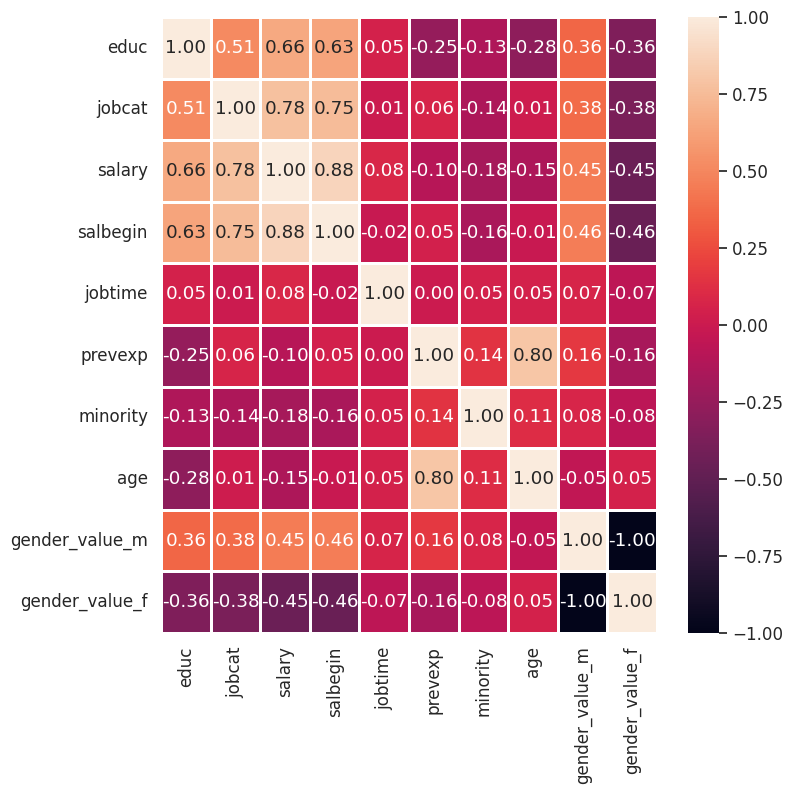

In [58]:
# Heatmap to show correlation between explanatory variables
sns.set(font_scale=1.1)
fig, ax = plt.subplots(figsize=(8,8))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, fmt=".2f", linewidths=1, ax=ax)

Finally, we rescale the whole data

In [59]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler().fit(df)
X_std = ss.transform(df)

## Computation of the PCA <a id="pca" />

Let's "fit" the PCA algorithm (in other words, let's compute the singular value decomposition)

In [60]:
sklearn_pca = PCA()
Y_sklearn = sklearn_pca.fit_transform(X_std)

Here the PCA is a full SVD (k=d, we have not yet applied any "reduction").

## Display of the explained variance of the eigenvectors. <a id="explained-variance" />

The first thing to do after fitting a PCA algorihtm is to plot the **explained variance** of each eigenvector (how much information from the original data does each vector contain).

We also compute how many of these vectors (in order) must be used to retain 90% of the variance of the original dataset (you can change that figure below)

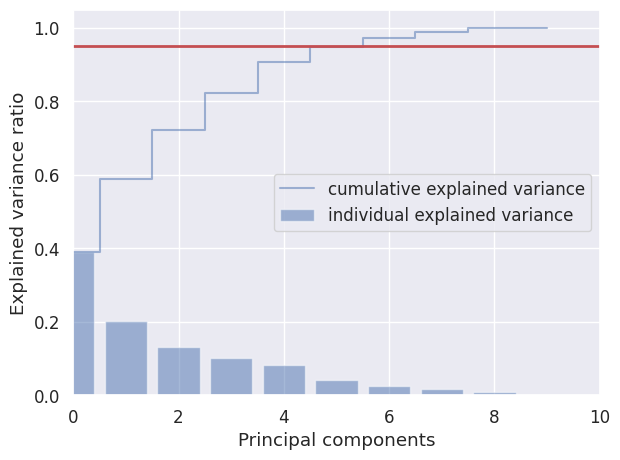

In [61]:
plt.bar(range(sklearn_pca.n_components_), sklearn_pca.explained_variance_ratio_, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(sklearn_pca.n_components_), [sklearn_pca.explained_variance_ratio_[:y].sum() for y in range(1,sklearn_pca.n_components_+1)], alpha=0.5, where='mid',label='cumulative explained variance')
plt.axhline(y=0.95, linewidth=2, color = 'r')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.xlim([0, sklearn_pca.n_components_])
plt.legend(loc='best')
plt.tight_layout()


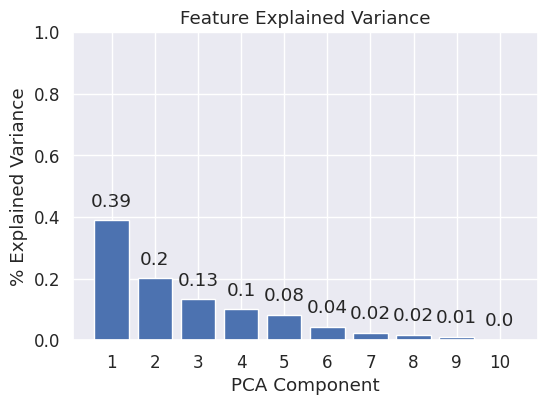

In [62]:
#Bar plot of explained_variance
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(sklearn_pca.n_components_) + 1,
    height = sklearn_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, sklearn_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(sklearn_pca.n_components_) + 1)
ax.set_ylim(0, 1)
ax.set_title('Feature Explained Variance')
ax.set_xlabel('PCA Component')
ax.set_ylabel('% Explained Variance');

In [63]:
# Show data from the chart
print ("Component explained variance:")
variances = pd.DataFrame(sklearn_pca.explained_variance_ratio_, columns=['Variances'])
variances_cum = pd.DataFrame(sklearn_pca.explained_variance_ratio_.cumsum(), columns=['Cumulative'])
frames = [variances, variances_cum] 
df_var = pd.concat(frames, sort=False, axis=1)
df_var

Component explained variance:


,Variances,Cumulative
0,0.389233,0.389233
1,0.200844,0.590077
2,0.132597,0.722674
3,0.100169,0.822843
4,0.083487,0.906331
5,0.042762,0.949092
6,0.024497,0.973589
7,0.016611,0.990200
8,0.009800,1.000000
9,0.000000,1.000000


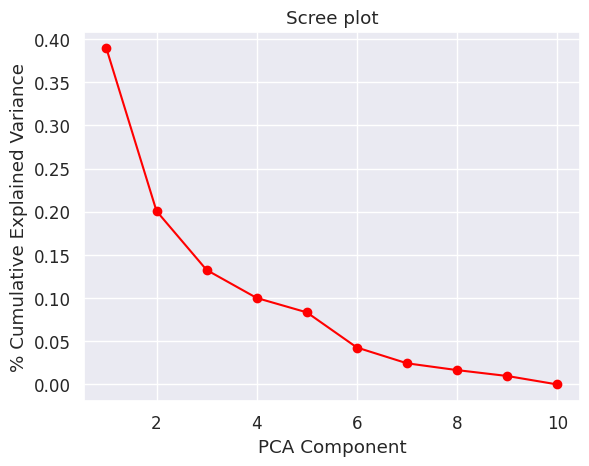

In [64]:
# Scree plot 
plt.plot(
    range(1,len(sklearn_pca.explained_variance_ratio_ )+1),
    sklearn_pca.explained_variance_ratio_,
    c='red', marker='o'
)
 
plt.xlabel('PCA Component')
plt.ylabel('% Cumulative Explained Variance')
plt.title('Scree plot')
plt.show()

## Retaining only some vectors <a id="final-pca" />

You should decide now how many components you want to keep and change the following parameter.

By default we keep the recommended value from the above figure

In [65]:
VARIANCE_TO_KEEP = 0.90
keep_recommend = [sklearn_pca.explained_variance_ratio_[:y].sum()>VARIANCE_TO_KEEP for y in range(1,sklearn_pca.n_components_+1)].count(False)
print("Number of components to keep to retain %s%% of the variance:" % (100*VARIANCE_TO_KEEP), keep_recommend, "out of the original", sklearn_pca.n_components_)
retained_components_number = keep_recommend

Number of components to keep to retain 90.0% of the variance: 4 out of the original 10


Let's run the PCA again but with a limited number of components this time

In [66]:
sklearn_pca_final = PCA(n_components=retained_components_number)
Y_sklearn_final = sklearn_pca_final.fit_transform(X_std)

## Visualizing the eigenvectors in the original feature space <a id="original-space" />

### Decomposition heatmap

Each of our eigenvectors has a linear decomposition in the original feature space.

To understand which features were the most important, we can see how our eigenvectors are made of each original feature.

In [67]:
# Shows loading factors = correlations between variables and factors
print ("Loading factors:")

dfloading=pd.DataFrame(
    data    = sklearn_pca_final.components_,
    columns = df.columns,
)

index_list=[]
for n in range(retained_components_number):
    index_list.append("PC"+str(n+1))

dfloading.index = index_list
dfloading

Loading factors:


,educ,jobcat,salary,salbegin,jobtime,prevexp,minority,age,gender_value_m,gender_value_f
PC1,0.378042,0.406190,0.456498,0.447590,0.031363,-0.016552,-0.074087,-0.079986,0.367575,-0.367575
PC2,-0.217732,0.028413,-0.080665,0.014570,0.057532,0.648912,0.233992,0.593949,0.237847,-0.237847
PC3,-0.049513,-0.303396,-0.200963,-0.257989,0.148637,-0.205375,0.415607,-0.352770,0.467497,-0.467497
PC4,0.078791,0.023998,0.099896,-0.012907,0.966683,-0.042123,0.068374,0.075239,-0.135063,0.135063


Each variable can be expressed as a lineal combination of Factors. For instance:
educ = 0.452923*PC1 -0.125929*PC2 -0.042881*PC3


Now we hide values lower than 0.2 or 0.3 to display better the relations

In [68]:
# Hide values so that it is clearer
dfloading2 = dfloading.where(abs(dfloading) > 0.3  , "")
dfloading2

,educ,jobcat,salary,salbegin,jobtime,prevexp,minority,age,gender_value_m,gender_value_f
PC1,0.378042,0.40619,0.456498,0.44759,,,,,0.367575,-0.367575
PC2,,,,,,0.648912,,0.593949,,
PC3,,-0.303396,,,,,0.415607,-0.35277,0.467497,-0.467497
PC4,,,,,0.966683,,,,,


n_components_: 4


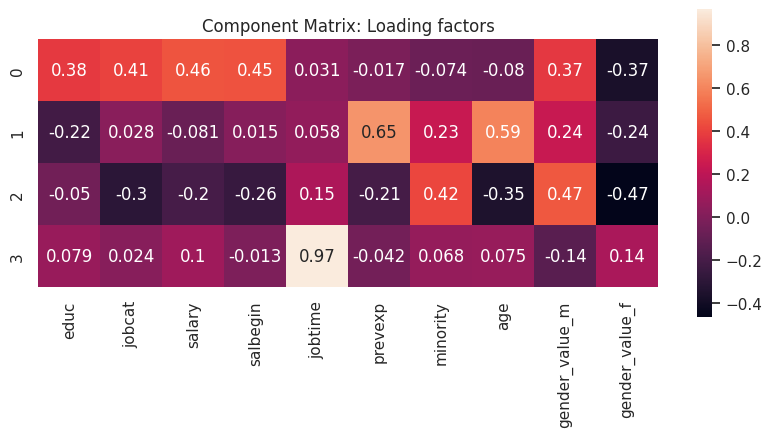

In [69]:
print("n_components_:", sklearn_pca_final.n_components_)
n_components_to_show = 4 if sklearn_pca_final.n_components_ > 4 else sklearn_pca_final.n_components_
n_input_features = sklearn_pca_final.components_.shape[1]  # Get the number of input features

# Create the DataFrame for PCA components
decomp_df = pd.DataFrame(sklearn_pca_final.components_[:n_components_to_show], columns=df.columns[:n_input_features])

# Limit the number of input features to 10 if there are more
if decomp_df.shape[1] > 10:
    decomp_df = decomp_df[decomp_df.columns[:10]]  # Only show up to 10 features

# Plot the heatmap
fig = plt.figure(figsize=(decomp_df.shape[1], n_components_to_show))  # Adjust figure size based on actual data
sns.set(font_scale=1)
sns.heatmap(decomp_df, square=True, annot=True).set(title='Component Matrix: Loading factors')
sns.set(font_scale=1)

plt.show()



### Communalities
In order to calculate communalities (% of information explained from each variable), we need to square the loading factors of each variable.

In [70]:
# Communalities
commun=[]

for col in dfloading.columns:
    commun.append((dfloading.iloc[0:3][col]**2).sum())
    
dfcommun = pd.DataFrame(commun,index=dfloading.columns, columns=["Communalities"])
dfcommun.sort_values("Communalities", ascending=False)

,Communalities
age,0.483620
prevexp,0.463539
gender_value_m,0.410236
gender_value_f,0.410236
salbegin,0.267108
jobcat,0.257847
salary,0.255283
minority,0.232970
educ,0.192775
jobtime,0.026386


/tmp/ipykernel_15337/3956447377.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=50)
/tmp/ipykernel_15337/3956447377.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xs[i], ys[i], "  " + varnames)


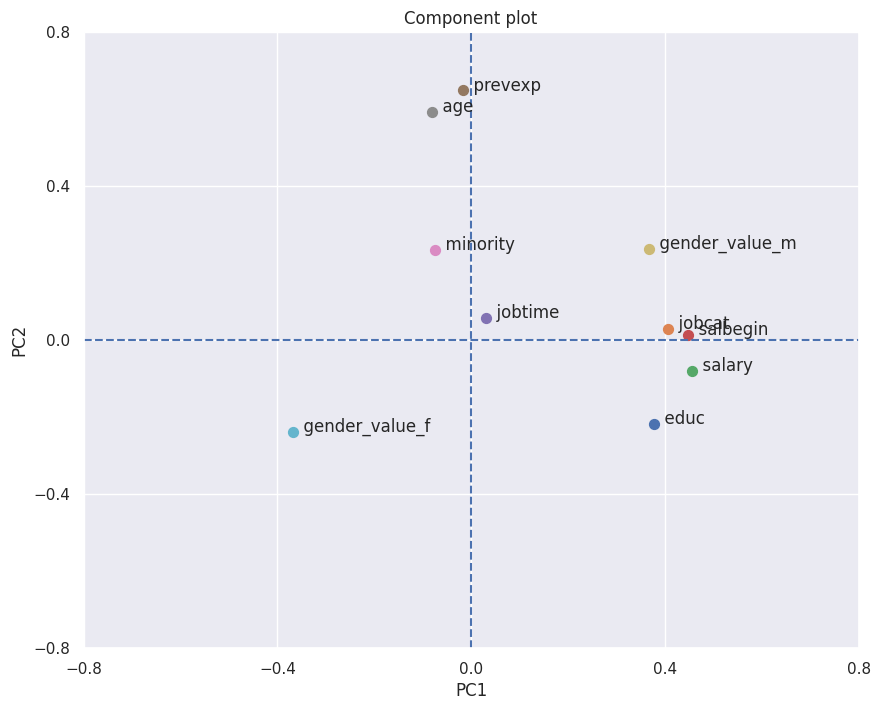

In [71]:
# Get the loadings of x and y axes
dfloadT = dfloading.T

xs = dfloadT.PC1
ys = dfloadT.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(dfloading.columns):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot')
plt.savefig('Component plot.png')
plt.show()

### Visualizing projected vectors

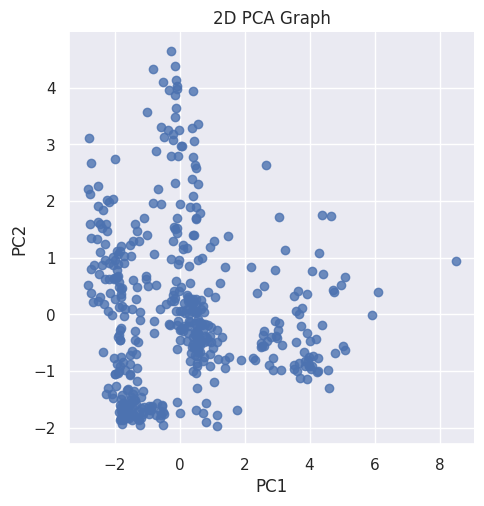

In [72]:
# Create dataframe of two components to display them
sklearn_pca_2 = PCA(n_components=2)
Y_sklearn_2 = sklearn_pca_2.fit_transform(X_std)
indx=np.arange(1, Y_sklearn_2.shape[0]+1)

pca_df_2 = pd.DataFrame(
    data=Y_sklearn_2, 
    columns=['PC1', 'PC2'])

sns.set()
sns.lmplot(
    x='PC1', 
    y='PC2', 
    data=pca_df_2, 
    fit_reg=False, 
    legend=True
    )
 
plt.title('2D PCA Graph')
plt.show()

In [73]:
# and now it shows the data Projections
pca_df_2

,PC1,PC2
0,2.934259,0.776478
1,1.152268,-0.281959
2,-1.986288,2.747007
3,-2.278121,0.954990
4,1.241092,0.559934
...,...,...
469,-0.172960,0.404188
470,0.250844,-0.204330
471,0.765741,-0.748800
472,-1.960125,0.641394


In [74]:
# Combine original data with components created
frames = [df_orig, pca_df_2]
dffinal = pd.concat(frames,axis=1)
dffinal.to_excel("Final.xlsx")

## Rotations

In [75]:
from sklearn.decomposition import PCA, FactorAnalysis

n_comps = 2

methods = [
    ("PCA", PCA()),
    ("Unrotated FA", FactorAnalysis()),
    ("Varimax FA", FactorAnalysis(rotation="varimax")),
]

num_methods = np.arange(3)

for ax, (method, fa) in zip(num_methods, methods):
    fa.set_params(n_components=n_comps)
    ss = StandardScaler().fit(df)
    X_std = ss.transform(df)
    Y_sklearn = fa.fit_transform(X_std)
    
    components = fa.components_.T
    if method == "Unrotated FA":
        df_factor = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    elif method == "Varimax FA":
        df_varimax = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
    else:
        df_pca = pd.DataFrame(components, columns = ['PC1','PC2'], index=df.columns)
        

In [76]:
print("PCA: ")
df_pca.where(abs(df_pca) > 0.3  , "")

PCA: 


,PC1,PC2
educ,0.378042,
jobcat,0.40619,
salary,0.456498,
salbegin,0.44759,
jobtime,,
prevexp,,0.648912
minority,,
age,,0.593949
gender_value_m,0.367575,
gender_value_f,-0.367575,


In [77]:
print("Unrotated Factor: ")
df_factor.where(abs(df_factor) > 0.3  , "")

Unrotated Factor: 


,PC1,PC2
educ,-0.305162,0.65893
jobcat,,0.816787
salary,,0.9415
salbegin,,0.928026
jobtime,,
prevexp,0.98202,
minority,,
age,0.816723,
gender_value_m,,0.525923
gender_value_f,,-0.525923


In [78]:
print("Varimax rotation: ")
df_varimax.where(abs(df_varimax) > 0.3  , "")

Varimax rotation: 


,PC1,PC2
educ,,0.678158
jobcat,,0.814544
salary,,0.950679
salbegin,,0.927268
jobtime,,
prevexp,0.984575,
minority,,
age,0.813781,
gender_value_m,,0.516277
gender_value_f,,-0.516277


/tmp/ipykernel_15337/1607364176.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(xs[i], ys[i], s=50)
/tmp/ipykernel_15337/1607364176.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(xs[i], ys[i], "  " + varnames)


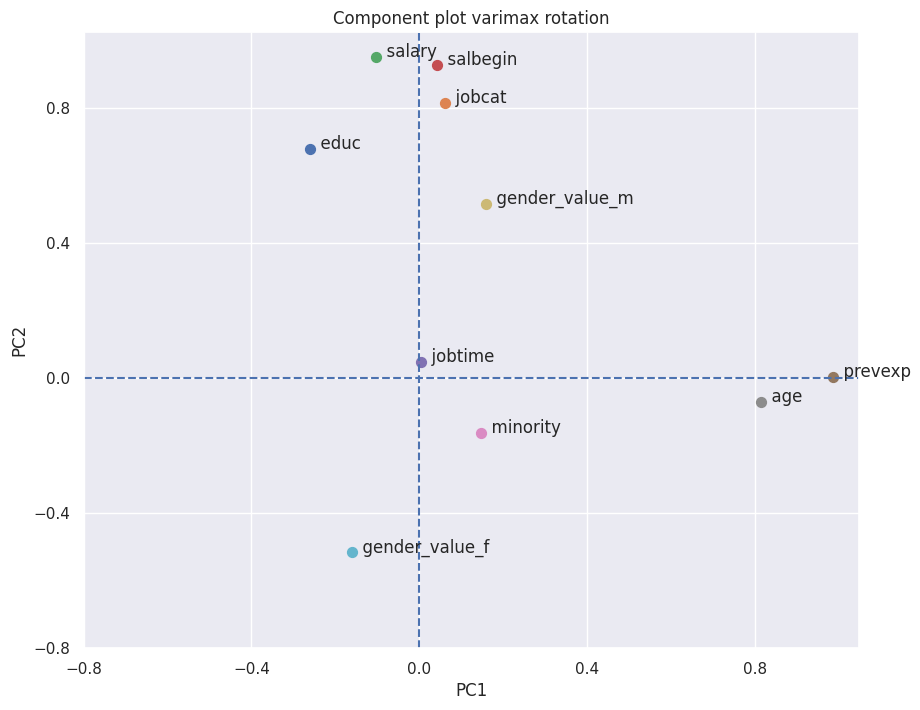

In [79]:
# Represent the component plot rotated
xs = df_varimax.PC1
ys = df_varimax.PC2
 
plt.figure(figsize = (10, 8))
plt.axvline(x = 0, color = 'b', linestyle = 'dashed')
plt.axhline(y = 0, color = 'b', linestyle = 'dashed')

# Plot the loadings on a scatterplot
for i, varnames in enumerate(df_varimax.T):
    plt.scatter(xs[i], ys[i], s=50)
    plt.text(xs[i], ys[i], "  " + varnames)
 
# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')
 
# Show plot
plt.title('Component plot varimax rotation')
plt.savefig('Component plot varimax rotation.png')
plt.show()